In [1]:
import sys, os, pygmt, importlib, re, time, glob, io
mod_path = '/home/581/da1339/AFIM/src/AFIM/src'
sys.path.insert(0, mod_path)
from sea_ice_toolbox         import SeaIceToolbox, SeaIceToolboxManager
from datetime                import timedelta, date, datetime
from pathlib                 import Path
from dask.distributed        import Client, LocalCluster
from dask.diagnostics        import ProgressBar
from pyproj                  import CRS, Transformer
from collections             import defaultdict
from scipy.interpolate       import interp1d
from tqdm                    import tqdm 
from matplotlib              import gridspec
from matplotlib.colors       import TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker       import ScalarFormatter
from matplotlib.patches      import Rectangle, Circle
from IPython.display         import Image, HTML, Video
from pyproj                  import Transformer
from pyresample.geometry     import AreaDefinition, SwathDefinition
from pyresample.kd_tree      import resample_nearest
import numpy                 as np
import pandas                as pd
import xarray                as xr
import xesmf                 as xe
import matplotlib.pyplot     as plt
import matplotlib.dates      as mdates
import matplotlib.animation  as animation
import warnings
warnings.filterwarnings("ignore", message="Sending large graph of size", category=UserWarning, module="distributed.client")

# Conceptual Model of Free-slip v No-slip

## helper functions

In [ ]:
def epm_from_cells(left_is_land, right_is_land):
    # E-edge exists only if both adjacent T cells are ocean
    return 0 if (left_is_land or right_is_land) else 1

def npm_from_cells(bottom_is_land, top_is_land):
    # N-edge exists only if both adjacent T cells are ocean
    return 0 if (bottom_is_land or top_is_land) else 1

def build_masks(land1, land2, land3, land4):
    c1, c2, c3, c4 = land1, land2, land3, land4
    epm = {
        "E(i,j)"    : epm_from_cells(c1, c4),
        "E(i+1,j)"  : epm_from_cells(c4, False),   # assume ocean outside to the right
        "E(i,j+1)"  : epm_from_cells(c2, c3),
        "E(i+1,j+1)": epm_from_cells(c3, False),
        "E(i,j+2)"  : epm_from_cells(c2, c3),      # mirror row above
        "E(i+1,j+2)": epm_from_cells(c3, False),
    }
    npm = {
        "N(i,j)"    : npm_from_cells(c1, c2),
        "N(i+1,j)"  : npm_from_cells(c4, c3),
        "N(i,j+1)"  : npm_from_cells(c2, False),   # assume ocean above
        "N(i+1,j+1)": npm_from_cells(c3, False),
    }
    return epm, npm

def build_masks_for_T(land1, land2, land3, land4):
    c1, c2, c3, c4 = land1, land2, land3, land4
    npm = {
        "N(i,j-1)"    : npm_from_cells(True,    c1),
        "N(i+1,j-1)"  : npm_from_cells(True,    c4),
        "N(i,j)"      : npm_from_cells(c1, c2),
        "N(i+1,j)"    : npm_from_cells(c4, c3),
        "N(i,j+1)"    : npm_from_cells(c2, True),
        "N(i+1,j+1)"  : npm_from_cells(c3, True),
    }
    epm = {
        "E(i-1,j)"    : epm_from_cells(True,   c1),
        "E(i-1,j+1)"  : epm_from_cells(True,   c2),
        "E(i,j)"      : epm_from_cells(c1, c4),
        "E(i,j+1)"    : epm_from_cells(c2, c3),
        "E(i+1,j)"    : epm_from_cells(c4, False),
        "E(i+1,j+1)"  : epm_from_cells(c3, False),
    }
    return epm, npm
    
def reflect(neigh_val, neigh_mask, self_val):
    # For free-slip: if neighbor masked, use self edge value (mirror); if both missing, 0.
    if neigh_mask == 1:
        return neigh_val
    return 0.0 if self_val is None else self_val

def shear_at_U_column(uE_down, m_down, uE_up, m_up, method):
    down_eff = uE_down if m_down == 1 else 0.0
    if method == "free-slip":
        up_eff = reflect(uE_up, m_up, down_eff)
    elif method == "no-slip":
        up_eff = uE_up if m_up == 1 else 0.0
    else:
        raise ValueError("method must be 'free-slip' or 'no-slip'")
    return up_eff - down_eff

def build_edge_velocities(land1, land2, land3, land4, flows):
    """
    Build per-edge velocities uE,vE and uN,vN from per-cell flows.
    Edge value = mean of available ocean neighbors; masked edges -> 0.
    """
    c1, c2, c3, c4 = land1, land2, land3, land4
    (U0,V0), (U1,V1), (U2,V2), (U3,V3) = flows
    epm, npm = build_masks(land1, land2, land3, land4)

    def avg(vals):
        arr = [x for x in vals if x is not None]
        return float(np.mean(arr)) if arr else 0.0

    # E components
    uE = {}
    vE = {}
    uE["E(i,j)"]     = (avg([U0 if not c1 else None, U3 if not c4 else None]) if epm["E(i,j)"]     else 0.0)
    vE["E(i,j)"]     = (avg([V0 if not c1 else None, V3 if not c4 else None]) if epm["E(i,j)"]     else 0.0)
    uE["E(i,j+1)"]   = (avg([U1 if not c2 else None, U2 if not c3 else None]) if epm["E(i,j+1)"]   else 0.0)
    vE["E(i,j+1)"]   = (avg([V1 if not c2 else None, V2 if not c3 else None]) if epm["E(i,j+1)"]   else 0.0)
    uE["E(i+1,j)"]   = (U3 if epm["E(i+1,j)"]   else 0.0)
    vE["E(i+1,j)"]   = (V3 if epm["E(i+1,j)"]   else 0.0)
    uE["E(i+1,j+1)"] = (U2 if epm["E(i+1,j+1)"] else 0.0)
    vE["E(i+1,j+1)"] = (V2 if epm["E(i+1,j+1)"] else 0.0)
    uE["E(i,j+2)"]   = (avg([U1, U2]) if epm["E(i,j+2)"]   else 0.0)
    vE["E(i,j+2)"]   = (avg([V1, V2]) if epm["E(i,j+2)"]   else 0.0)
    uE["E(i+1,j+2)"] = (U2 if epm["E(i+1,j+2)"] else 0.0)
    vE["E(i+1,j+2)"] = (V2 if epm["E(i+1,j+2)"] else 0.0)

    # N components
    uN = {}
    vN = {}
    uN["N(i,j)"]     = (avg([U0 if not c1 else None, U1 if not c2 else None]) if npm["N(i,j)"]     else 0.0)
    vN["N(i,j)"]     = (avg([V0 if not c1 else None, V1 if not c2 else None]) if npm["N(i,j)"]     else 0.0)
    uN["N(i+1,j)"]   = (avg([U3 if not c4 else None, U2 if not c3 else None]) if npm["N(i+1,j)"]   else 0.0)
    vN["N(i+1,j)"]   = (avg([V3 if not c4 else None, V2 if not c3 else None]) if npm["N(i+1,j)"]   else 0.0)
    uN["N(i,j+1)"]   = (U1 if npm["N(i,j+1)"]   else 0.0)
    vN["N(i,j+1)"]   = (V1 if npm["N(i,j+1)"]   else 0.0)
    uN["N(i+1,j+1)"] = (U2 if npm["N(i+1,j+1)"] else 0.0)
    vN["N(i+1,j+1)"] = (V2 if npm["N(i+1,j+1)"] else 0.0)

    return epm, npm, uE, vE, uN, vN

def compute_shears_for_case(land_tuple, flows, method):
    land1, land2, land3, land4 = land_tuple
    epm, npm, uE, vE, uN, vN = build_edge_velocities(land1, land2, land3, land4, flows)

    def horiz_contrib(left_key, right_key):
        left_v  = vN[left_key]  if npm[left_key]  == 1 else 0.0
        right_v = vN[right_key] if npm[right_key] == 1 else (left_v if method=="free-slip" else 0.0)
        return float(right_v - left_v)

    def shear_U_ij():
        du = shear_at_U_column(uE["E(i,j)"], epm["E(i,j)"], uE["E(i,j+1)"], epm["E(i,j+1)"], method)
        dv = horiz_contrib("N(i,j)", "N(i+1,j)")
        return du + dv

    def shear_U_ip1j():
        du = shear_at_U_column(uE["E(i+1,j)"], epm["E(i+1,j)"], uE["E(i+1,j+1)"], epm["E(i+1,j+1)"], method)
        left_v  = vN["N(i+1,j)"] if npm["N(i+1,j)"] == 1 else 0.0
        right_v = left_v if method=="free-slip" else 0.0
        dv = float(right_v - left_v)
        return du + dv

    def shear_U_ijp1():
        du = shear_at_U_column(uE["E(i,j+1)"], epm["E(i,j+1)"], uE["E(i,j+2)"], epm["E(i,j+2)"], method)
        dv = horiz_contrib("N(i,j+1)", "N(i+1,j+1)")
        return du + dv

    def shear_U_ip1jp1():
        du = shear_at_U_column(uE["E(i+1,j+1)"], epm["E(i+1,j+1)"], uE["E(i+1,j+2)"], epm["E(i+1,j+2)"], method)
        left_v  = vN["N(i+1,j+1)"] if npm["N(i+1,j+1)"] == 1 else 0.0
        right_v = left_v if method=="free-slip" else 0.0
        dv = float(right_v - left_v)
        return du + dv

    return dict(
        epm=epm, npm=npm, uE=uE, vE=vE, uN=uN, vN=vN,
        shear={
            "U(i,j)"     : shear_U_ij(),
            "U(i+1,j)"   : shear_U_ip1j(),
            "U(i,j+1)"   : shear_U_ijp1(),
            "U(i+1,j+1)" : shear_U_ip1jp1(),
        }
    )

def sign_label(x):
    return "0" if np.isclose(x, 0.0, atol=1e-12) else (">0" if x > 0 else "<0")

def build_edge_velocities_for_T(land1, land2, land3, land4, flows):
    """
    Build uN, vE on all needed edges using per-cell flows.
    Edge value = mean of available ocean neighbors (those not land);
    if no neighbors (masked), value is 0.
    """
    c1, c2, c3, c4 = land1, land2, land3, land4
    (U0,V0), (U1,V1), (U2,V2), (U3,V3) = flows
    epm, npm = build_masks_for_T(land1, land2, land3, land4)

    def avg(vals):
        arr = [x for x in vals if x is not None]
        return float(np.mean(arr)) if arr else 0.0

    # u on N edges (component along x)
    uN = {}
    # N(i,j-1): between "outside bottom" and c1 (mirror → only c1 contributes if ocean)
    uN["N(i,j-1)"]   = (U0 if npm["N(i,j-1)"]   else 0.0) if not c1 else 0.0
    uN["N(i+1,j-1)"] = (U3 if npm["N(i+1,j-1)"] else 0.0) if not c4 else 0.0
    # interior N edges
    uN["N(i,j)"]     = avg([U0 if not c1 else None, U1 if not c2 else None]) if npm["N(i,j)"]     else 0.0
    uN["N(i+1,j)"]   = avg([U3 if not c4 else None, U2 if not c3 else None]) if npm["N(i+1,j)"]   else 0.0
    # top outside mirrors
    uN["N(i,j+1)"]   = (U1 if npm["N(i,j+1)"]   else 0.0) if not c2 else 0.0
    uN["N(i+1,j+1)"] = (U2 if npm["N(i+1,j+1)"] else 0.0) if not c3 else 0.0

    # v on E edges (component along y)
    vE = {}
    # left outside mirrors
    vE["E(i-1,j)"]   = (V0 if epm["E(i-1,j)"]   else 0.0) if not c1 else 0.0
    vE["E(i-1,j+1)"] = (V1 if epm["E(i-1,j+1)"] else 0.0) if not c2 else 0.0
    # interior E edges
    vE["E(i,j)"]     = avg([V0 if not c1 else None, V3 if not c4 else None]) if epm["E(i,j)"]     else 0.0
    vE["E(i,j+1)"]   = avg([V1 if not c2 else None, V2 if not c3 else None]) if epm["E(i,j+1)"]   else 0.0
    # right outside (assume ocean to right → use only inside neighbor)
    vE["E(i+1,j)"]   = (V3 if epm["E(i+1,j)"]   else 0.0) if not c4 else 0.0
    vE["E(i+1,j+1)"] = (V2 if epm["E(i+1,j+1)"] else 0.0) if not c3 else 0.0

    return epm, npm, uN, vE

# shearT for a given T-cell center using reflection/no-slip on the stencil
def shearT_at_T(uN_top, m_top, uN_bot, m_bot, vE_right, m_right, vE_left, m_left, method):
    # uniform metrics → dxT=dyT=dxN=dyE=1
    if method == "free-slip":
        top_eff = uN_top if m_top == 1 else reflect(uN_top, m_top, uN_bot if m_bot==1 else 0.0)
        bot_eff = uN_bot if m_bot == 1 else reflect(uN_bot, m_bot, uN_top if m_top==1 else 0.0)
        right_eff = vE_right if m_right == 1 else reflect(vE_right, m_right, vE_left if m_left==1 else 0.0)
        left_eff  = vE_left  if m_left  == 1 else reflect(vE_left,  m_left,  vE_right if m_right==1 else 0.0)
    elif method == "no-slip":
        top_eff   = uN_top   if m_top   == 1 else 0.0
        bot_eff   = uN_bot   if m_bot   == 1 else 0.0
        right_eff = vE_right if m_right == 1 else 0.0
        left_eff  = vE_left  if m_left  == 1 else 0.0
    else:
        raise ValueError("method must be 'free-slip' or 'no-slip'")

    return (top_eff - bot_eff) + (right_eff - left_eff)

def build_full_edge_velocities_for_T_plotting(land1, land2, land3, land4, flows):
    """
    Build uE, vE, uN, vN and masks epm, npm for plotting, covering:
      E:  E(i-1,j), E(i,j), E(i+1,j), E(i-1,j+1), E(i,j+1), E(i+1,j+1)
      N:  N(i,j-1), N(i,j), N(i,j+1), N(i+1,j-1), N(i+1,j), N(i+1,j+1)
    uE and vN are not needed by shear_T but are included so the plot can show
    both components at both edge types (like draw_case).
    """
    c1, c2, c3, c4 = land1, land2, land3, land4
    (U0,V0), (U1,V1), (U2,V2), (U3,V3) = flows

    # reuse your masks for T-stencil
    epm, npm = build_masks_for_T(land1, land2, land3, land4)

    def avg(vals):
        arr = [x for x in vals if x is not None]
        return float(np.mean(arr)) if arr else 0.0

    # --- E edges (vertical) : build BOTH uE and vE for plotting
    uE, vE = {}, {}

    # left outside (mirror left: only left cell contributes if ocean)
    uE["E(i-1,j)"]   = (U0 if epm["E(i-1,j)"]   else 0.0) if not c1 else 0.0
    vE["E(i-1,j)"]   = (V0 if epm["E(i-1,j)"]   else 0.0) if not c1 else 0.0
    uE["E(i-1,j+1)"] = (U1 if epm["E(i-1,j+1)"] else 0.0) if not c2 else 0.0
    vE["E(i-1,j+1)"] = (V1 if epm["E(i-1,j+1)"] else 0.0) if not c2 else 0.0

    # interior column x=i
    uE["E(i,j)"]     = avg([U0 if not c1 else None, U3 if not c4 else None]) if epm["E(i,j)"]     else 0.0
    vE["E(i,j)"]     = avg([V0 if not c1 else None, V3 if not c4 else None]) if epm["E(i,j)"]     else 0.0
    uE["E(i,j+1)"]   = avg([U1 if not c2 else None, U2 if not c3 else None]) if epm["E(i,j+1)"]   else 0.0
    vE["E(i,j+1)"]   = avg([V1 if not c2 else None, V2 if not c3 else None]) if epm["E(i,j+1)"]   else 0.0

    # right outside (assume ocean to the right → use only right cell if ocean)
    uE["E(i+1,j)"]   = (U3 if epm["E(i+1,j)"]   else 0.0) if not c4 else 0.0
    vE["E(i+1,j)"]   = (V3 if epm["E(i+1,j)"]   else 0.0) if not c4 else 0.0
    uE["E(i+1,j+1)"] = (U2 if epm["E(i+1,j+1)"] else 0.0) if not c3 else 0.0
    vE["E(i+1,j+1)"] = (V2 if epm["E(i+1,j+1)"] else 0.0) if not c3 else 0.0

    # --- N edges (horizontal) : build BOTH uN and vN for plotting
    uN, vN = {}, {}

    # bottom outside (mirror bottom: only bottom cell contributes if ocean)
    uN["N(i,j-1)"]   = (U0 if npm["N(i,j-1)"]   else 0.0) if not c1 else 0.0
    vN["N(i,j-1)"]   = (V0 if npm["N(i,j-1)"]   else 0.0) if not c1 else 0.0
    uN["N(i+1,j-1)"] = (U3 if npm["N(i+1,j-1)"] else 0.0) if not c4 else 0.0
    vN["N(i+1,j-1)"] = (V3 if npm["N(i+1,j-1)"] else 0.0) if not c4 else 0.0

    # interior row y=j
    uN["N(i,j)"]     = avg([U0 if not c1 else None, U1 if not c2 else None]) if npm["N(i,j)"]     else 0.0
    vN["N(i,j)"]     = avg([V0 if not c1 else None, V1 if not c2 else None]) if npm["N(i,j)"]     else 0.0
    uN["N(i+1,j)"]   = avg([U3 if not c4 else None, U2 if not c3 else None]) if npm["N(i+1,j)"]   else 0.0
    vN["N(i+1,j)"]   = avg([V3 if not c4 else None, V2 if not c3 else None]) if npm["N(i+1,j)"]   else 0.0

    # top outside (mirror top: only top cell contributes if ocean)
    uN["N(i,j+1)"]   = (U1 if npm["N(i,j+1)"]   else 0.0) if not c2 else 0.0
    vN["N(i,j+1)"]   = (V1 if npm["N(i,j+1)"]   else 0.0) if not c2 else 0.0
    uN["N(i+1,j+1)"] = (U2 if npm["N(i+1,j+1)"] else 0.0) if not c3 else 0.0
    vN["N(i+1,j+1)"] = (V2 if npm["N(i+1,j+1)"] else 0.0) if not c3 else 0.0

    return epm, npm, uE, vE, uN, vN


def compute_shearT_case(land_tuple, flows, method):
    land1, land2, land3, land4 = land_tuple
    epm, npm, uN, vE = build_edge_velocities_for_T(land1, land2, land3, land4, flows)

    # shear at four T cells:
    # T(i,j): uses N(i,j), N(i,j-1) and E(i,j), E(i-1,j)
    s_Tij = shearT_at_T(
        uN_top=uN["N(i,j)"],   m_top=npm["N(i,j)"],
        uN_bot=uN["N(i,j-1)"], m_bot=npm["N(i,j-1)"],
        vE_right=vE["E(i,j)"], m_right=epm["E(i,j)"],
        vE_left=vE["E(i-1,j)"], m_left=epm["E(i-1,j)"],
        method=method
    )

    # T(i+1,j): N(i+1,j), N(i+1,j-1); E(i+1,j), E(i,j)
    s_Tip1j = shearT_at_T(
        uN_top=uN["N(i+1,j)"],   m_top=npm["N(i+1,j)"],
        uN_bot=uN["N(i+1,j-1)"], m_bot=npm["N(i+1,j-1)"],
        vE_right=vE["E(i+1,j)"], m_right=epm["E(i+1,j)"],
        vE_left=vE["E(i,j)"],    m_left=epm["E(i,j)"],
        method=method
    )

    # T(i,j+1): N(i,j+1), N(i,j); E(i,j+1), E(i-1,j+1)
    s_Tijp1 = shearT_at_T(
        uN_top=uN["N(i,j+1)"], m_top=npm["N(i,j+1)"],
        uN_bot=uN["N(i,j)"],   m_bot=npm["N(i,j)"],
        vE_right=vE["E(i,j+1)"], m_right=epm["E(i,j+1)"],
        vE_left=vE["E(i-1,j+1)"], m_left=epm["E(i-1,j+1)"],
        method=method
    )

    # T(i+1,j+1): N(i+1,j+1), N(i+1,j); E(i+1,j+1), E(i,j+1)
    s_Tip1jp1 = shearT_at_T(
        uN_top=uN["N(i+1,j+1)"], m_top=npm["N(i+1,j+1)"],
        uN_bot=uN["N(i+1,j)"],   m_bot=npm["N(i+1,j)"],
        vE_right=vE["E(i+1,j+1)"], m_right=epm["E(i+1,j+1)"],
        vE_left=vE["E(i,j+1)"],    m_left=epm["E(i,j+1)"],
        method=method
    )

    # Build full fields for plotting
    epm_plot, npm_plot, uE, vE_full, uN_full, vN = build_full_edge_velocities_for_T_plotting(
        land1, land2, land3, land4, flows
    )

    return dict(epm=epm_plot, npm=npm_plot, uE=uE, vE=vE_full, uN=uN_full, vN=vN,
                shearT={"T(i,j)"      : s_Tij,
                        "T(i+1,j)"    : s_Tip1j,
                        "T(i,j+1)"    : s_Tijp1,
                        "T(i+1,j+1)"  : s_Tip1jp1,})

def draw_case(case_name, land_tuple, data, flows, method):
    (U0,V0), (U1,V1), (U2,V2), (U3,V3) = flows
    land1, land2, land3, land4 = land_tuple
    epm, npm, uE, vE, uN, vN = data["epm"], data["npm"], data["uE"], data["vE"], data["uN"], data["vN"]

    fig, ax = plt.subplots(figsize=(6,6))
    cells = [(0,0,land1,"c1"), (0,1,land2,"c2"), (1,1,land3,"c3"), (1,0,land4,"c4")]
    for x0, y0, is_land, label in cells:
        rect = Rectangle((x0,y0), 1,1, fill=False, hatch='//' if is_land else None)
        ax.add_patch(rect)
        ax.text(x0+0.5, y0+0.5, label, ha='center', va='center', fontsize=9)

    E_centers = {
        "E(i,j)"    : (1.0, 0.5),
        "E(i+1,j)"  : (2.0, 0.5),
        "E(i,j+1)"  : (1.0, 1.5),
        "E(i+1,j+1)": (2.0, 1.5),
        "E(i,j+2)"  : (1.0, 2.5),
        "E(i+1,j+2)": (2.0, 2.5),
    }
    N_centers = {
        "N(i,j)"    : (0.5, 1.0),
        "N(i+1,j)"  : (1.5, 1.0),
        "N(i,j+1)"  : (0.5, 2.0),
        "N(i+1,j+1)": (1.5, 2.0),
    }

    # per-edge arrows (blue=u, red=v)
    for k, (x,y) in E_centers.items():
        alpha = 1.0 if epm.get(k,0)==1 else 0.2
        ax.arrow(x, y, 0.20*uE[k], 0, length_includes_head=True, head_width=0.06, color="blue", alpha=alpha)
        ax.arrow(x, y, 0, 0.20*vE[k], length_includes_head=True, head_width=0.06, color="red", alpha=alpha)
        ax.text(x, y-0.18, k, ha='center', va='center', fontsize=8)

    for k, (x,y) in N_centers.items():
        alpha = 1.0 if npm.get(k,0)==1 else 0.2
        ax.arrow(x, y, 0.20*uN[k], 0, length_includes_head=True, head_width=0.06, color="blue", alpha=alpha)
        ax.arrow(x, y, 0, 0.20*vN[k], length_includes_head=True, head_width=0.06, color="red", alpha=alpha)
        ax.text(x-0.22, y, k, ha='center', va='center', fontsize=8, rotation=90)

    U_points = {"U(i,j)": (1,1), "U(i+1,j)": (2,1), "U(i,j+1)": (1,2), "U(i+1,j+1)": (2,2)}
    for uname, (ux,uy) in U_points.items():
        color = "royalblue" if uname == "U(i,j)" else "grey"
        radius = 0.06 if uname == "U(i,j)" else 0.045
        ax.add_patch(Circle((ux,uy), radius, color=color))
        ax.text(ux, uy-0.24 if uname!="U(i,j)" else uy-0.29,
                f"{uname}: {sign_label(data['shear'][uname])}", ha='center', va='center', fontsize=8)

    def sgn(u): return "=0" if np.isclose(u,0) else (">0" if u>0 else "<0")
    title = (f"{case_name} | c1(u,v)=({sgn(U0)},{sgn(V0)})  "
             f"c2=({sgn(U1)},{sgn(V1)})  c3=({sgn(U2)},{sgn(V2)})  c4=({sgn(U3)},{sgn(V3)})"
             f" | method: {method}")
    ax.set_title(title, fontsize=10)

    ax.set_xlim(-0.1, 2.6); ax.set_ylim(-0.1, 2.8)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout()
    plt.show()

# Simple plot marking T cells and shear sign
def draw_case_T(case_name, land_tuple, data, flows, method):
    (U0,V0), (U1,V1), (U2,V2), (U3,V3) = flows
    land1, land2, land3, land4 = land_tuple

    epm, npm = data["epm"], data["npm"]
    uE, vE, uN, vN = data["uE"], data["vE"], data["uN"], data["vN"]

    fig, ax = plt.subplots(figsize=(6,6))

    # T-cells
    cells = [(0,0,land1,"c1"), (0,1,land2,"c2"), (1,1,land3,"c3"), (1,0,land4,"c4")]
    for x0, y0, is_land, label in cells:
        rect = Rectangle((x0,y0), 1,1, fill=False, hatch='//' if is_land else None)
        ax.add_patch(rect)
        ax.text(x0+0.5, y0+0.5, label, ha='center', va='center', fontsize=9)

    # E-edge centers: include left/outside and right/outside (needed by shear_T stencil)
    E_centers = {
        "E(i-1,j)"   : (0.0, 0.5),
        "E(i,j)"     : (1.0, 0.5),
        "E(i+1,j)"   : (2.0, 0.5),
        "E(i-1,j+1)" : (0.0, 1.5),
        "E(i,j+1)"   : (1.0, 1.5),
        "E(i+1,j+1)" : (2.0, 1.5),
    }

    # N-edge centers: include bottom/outside and top/outside
    N_centers = {
        "N(i,j-1)"   : (0.5, 0.0),
        "N(i,j)"     : (0.5, 1.0),
        "N(i,j+1)"   : (0.5, 2.0),
        "N(i+1,j-1)" : (1.5, 0.0),
        "N(i+1,j)"   : (1.5, 1.0),
        "N(i+1,j+1)" : (1.5, 2.0),
    }

    # arrows on E edges (blue=uE, red=vE)
    for k, (x,y) in E_centers.items():
        alpha = 1.0 if epm.get(k,0)==1 else 0.2
        ax.arrow(x, y, 0.20*uE.get(k,0.0), 0,   length_includes_head=True, head_width=0.06, color="blue", alpha=alpha)
        ax.arrow(x, y, 0,   0.20*vE.get(k,0.0), length_includes_head=True, head_width=0.06, color="red",  alpha=alpha)
        ax.text(x, y-0.18 if "j+1" not in k else y+0.18, k, ha='center', va='center', fontsize=8)

    # arrows on N edges (blue=uN, red=vN)
    for k, (x,y) in N_centers.items():
        alpha = 1.0 if npm.get(k,0)==1 else 0.2
        ax.arrow(x, y, 0.20*uN.get(k,0.0), 0,   length_includes_head=True, head_width=0.06, color="blue", alpha=alpha)
        ax.arrow(x, y, 0,   0.20*vN.get(k,0.0), length_includes_head=True, head_width=0.06, color="red",  alpha=alpha)
        ax.text(x-0.22 if "i+1" not in k else x+0.22, y, k, ha='center', va='center', fontsize=8, rotation=90)

    # T points (cell centers) with shear_T sign
    def sign_label(x): return "0" if np.isclose(x,0.0,1e-12) else (">0" if x>0 else "<0")
    T_points = {"T(i,j)": (0.5,0.5), "T(i+1,j)": (1.5,0.5), "T(i,j+1)": (0.5,1.5), "T(i+1,j+1)": (1.5,1.5)}
    for tname, (x,y) in T_points.items():
        ax.add_patch(Circle((x,y), 0.05, color="royalblue"))
        ax.text(x, y-0.22, f"{tname}: {sign_label(data['shearT'][tname])}", ha='center', va='center', fontsize=9)

    # title
    def sgn(u): return "=0" if np.isclose(u,0) else (">0" if u>0 else "<0")
    title = (f"{case_name} | c1(u,v)=({sgn(U0)},{sgn(V0)})  "
             f"c2=({sgn(U1)},{sgn(V1)})  c3=({sgn(U2)},{sgn(V2)})  c4=({sgn(U3)},{sgn(V3)})"
             f" | method: {method}")
    ax.set_title(title, fontsize=10)

    ax.set_xlim(-0.4, 2.4); ax.set_ylim(-0.4, 2.4)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout()
    plt.show()

## Define cases

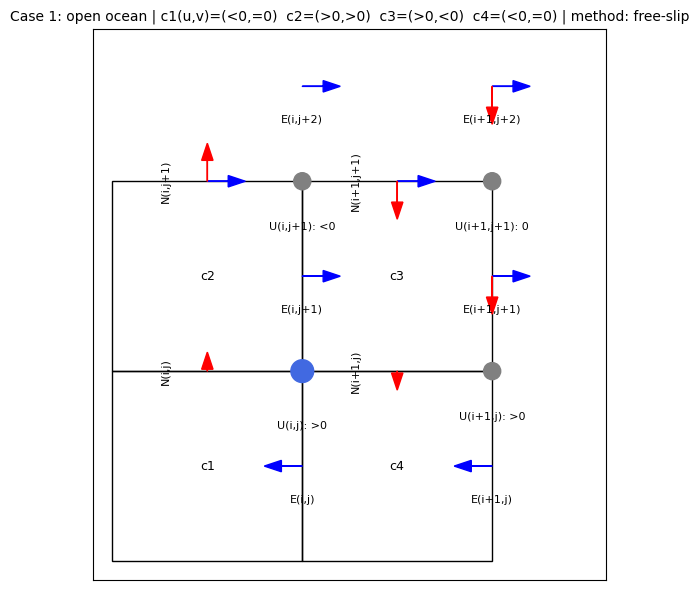

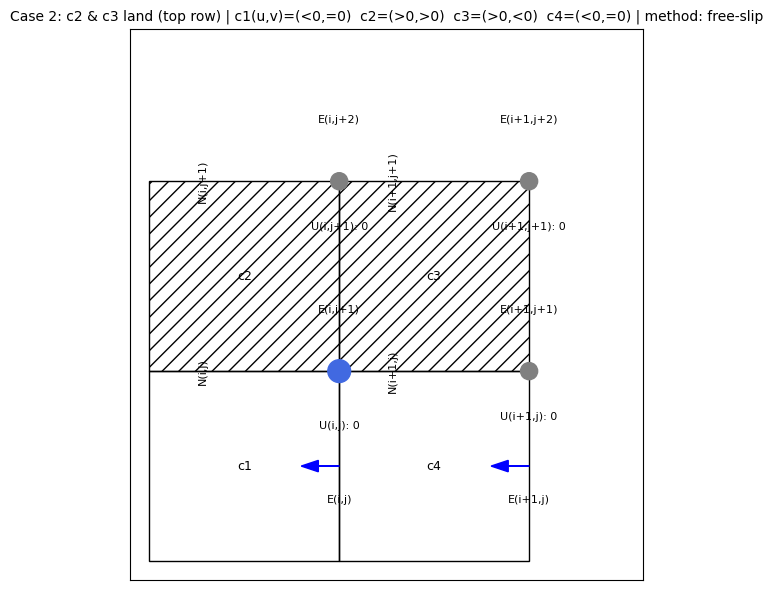

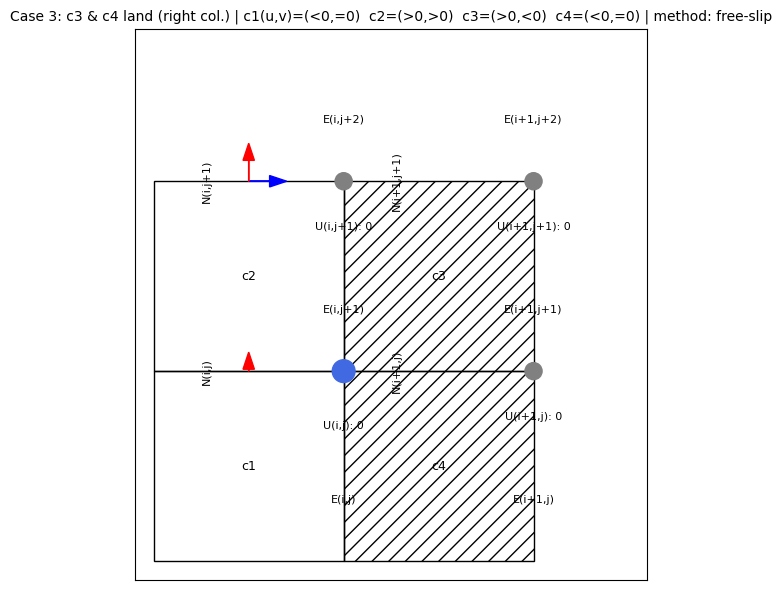

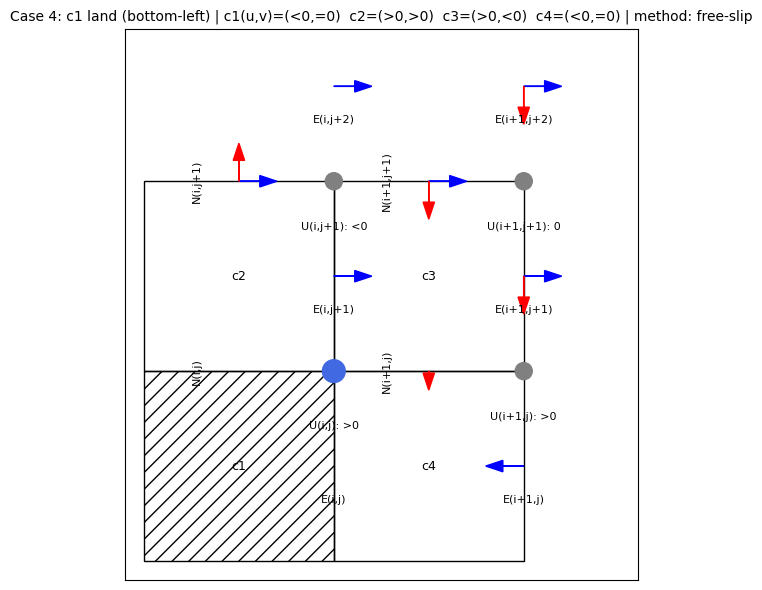

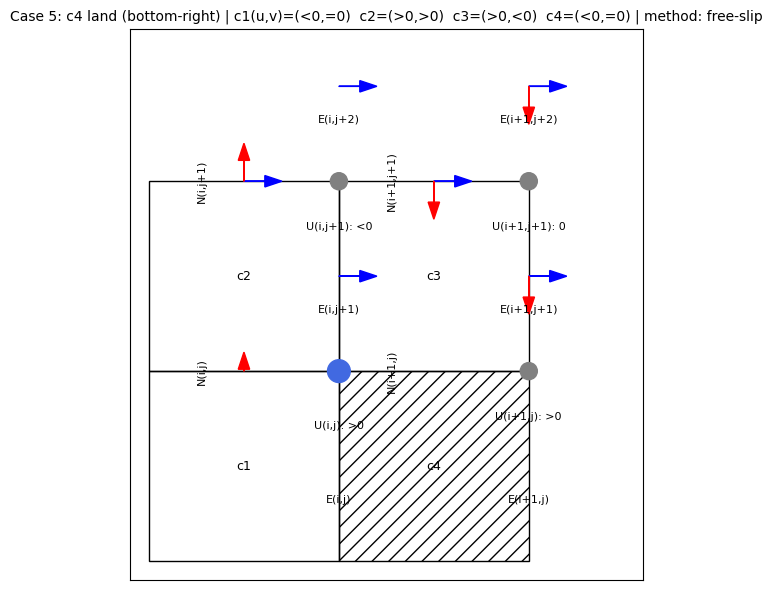

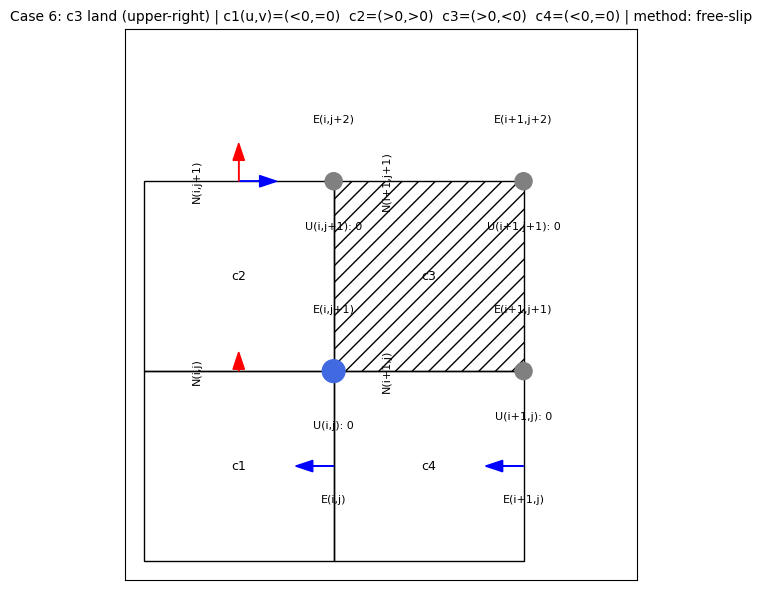

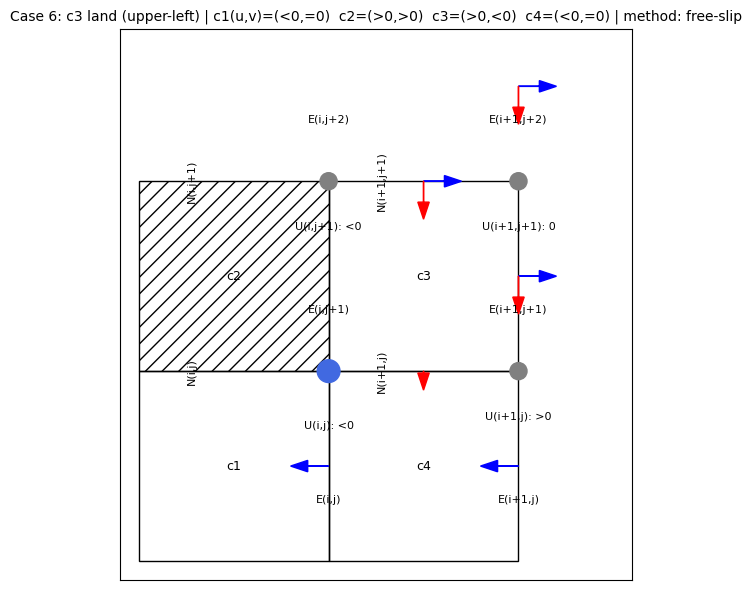

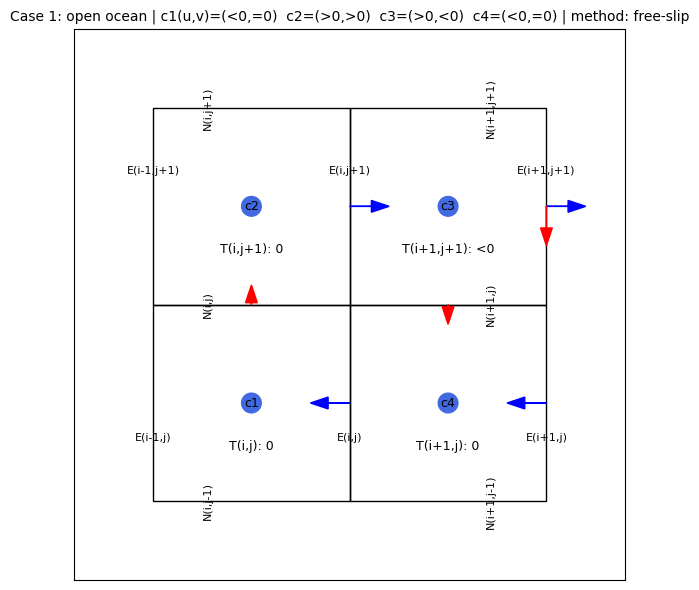

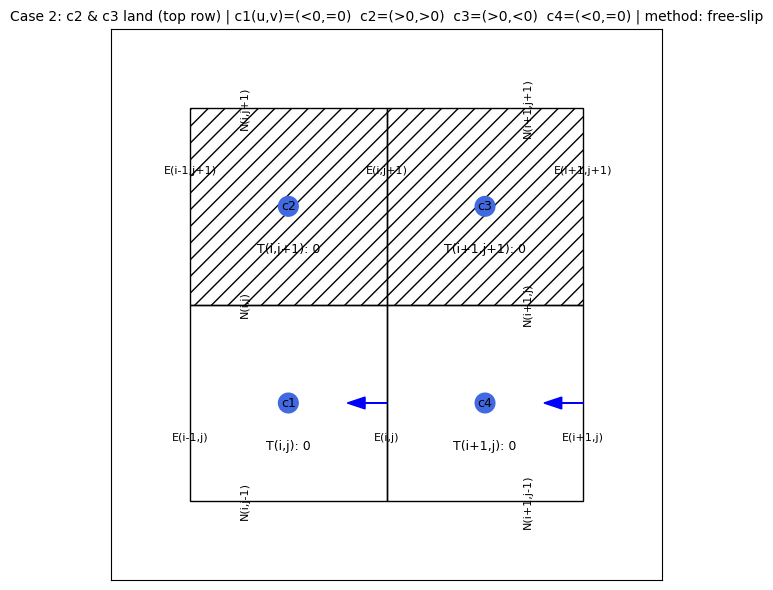

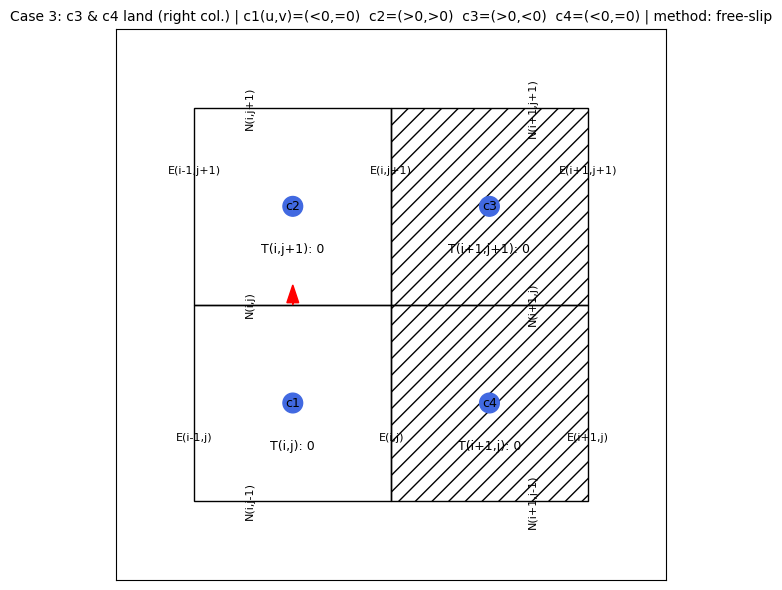

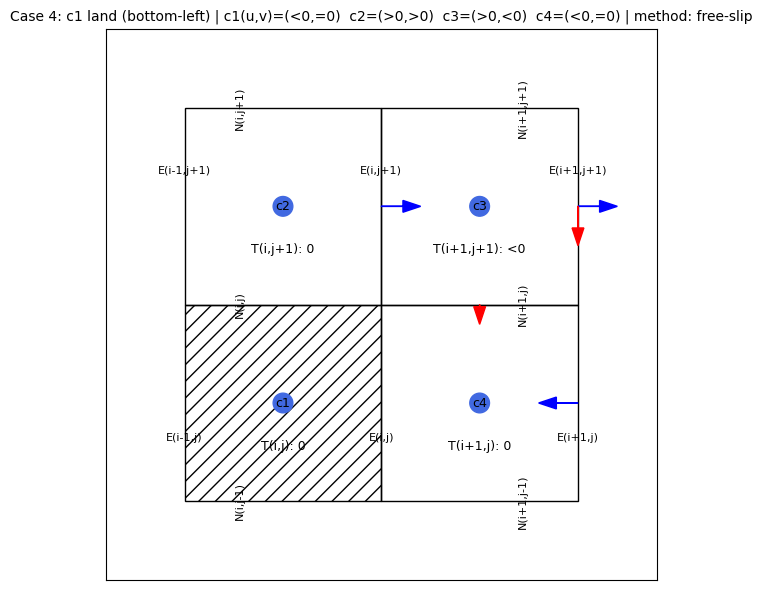

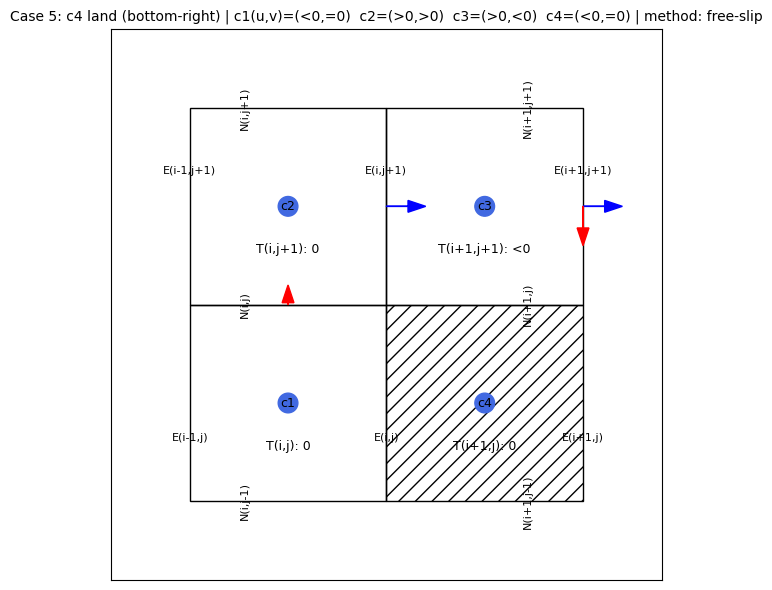

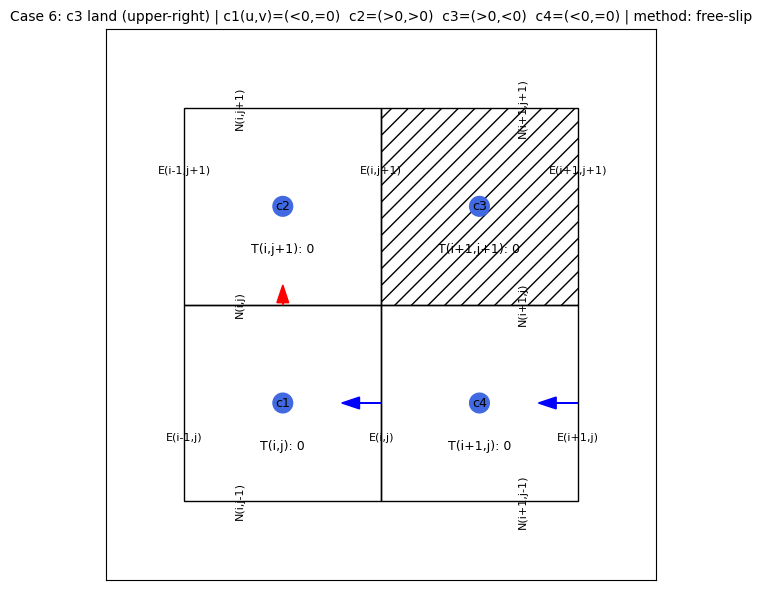

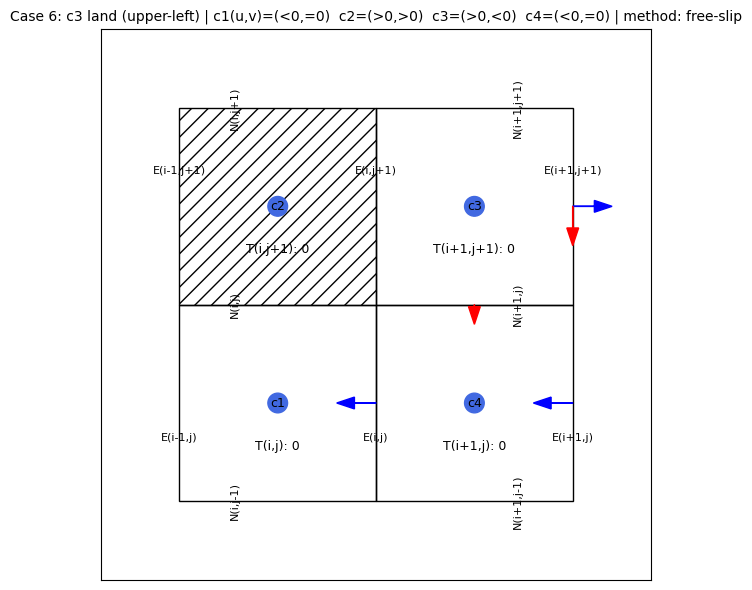

In [37]:
# -------------------- configurable per-cell flows --------------------
# c1 (bottom-left), c2 (top-left), c3 (top-right), c4 (bottom-right)
u0, v0 = -1.0, 0.0   # c1
u1, v1 =  1.0, 1.0   # c2
u2, v2 =  1.0, -1.0   # c3
u3, v3 = -1.0, 0.0   # c4

cases = [
    ("Case 1: open ocean",                 (False, False, False, False)),
    ("Case 2: c2 & c3 land (top row)",     (False,  True,  True,  False)),
    ("Case 3: c3 & c4 land (right col.)",  (False, False, True,   True )),
    ("Case 4: c1 land (bottom-left)",      (True,  False, False,  False)),
    ("Case 5: c4 land (bottom-right)",     (False, False, False,  True )),
    ("Case 6: c3 land (upper-right)",     (False, False, True,  False )),
    ("Case 6: c3 land (upper-left)",     (False, True, False,  False ))
]

# Choose boundary treatment
method = "free-slip"   # "free-slip" (Neumann mirror) or "no-slip" (Dirichlet zero)

# -------------------- run and display --------------------
flows = ((u0,v0),(u1,v1),(u2,v2),(u3,v3))
rows = []
for case_name, land_tuple in cases:
    data = compute_shears_for_case(land_tuple, flows, method)
    rows.append({
        "case": case_name, "method": method,
        **{f"shear_{k}": v for k,v in data["shear"].items()}
    })
    draw_case(case_name, land_tuple, data, flows, method)
for case_name, land_tuple in cases:
    data = compute_shearT_case(land_tuple, flows, method)
    rows.append({"case": case_name, "method": method, **{f"shearT_{k}": v for k,v in data["shearT"].items()}})
    draw_case_T(case_name, land_tuple, data, flows, method)


In [ ]:
# native_cgrid_panel_anim_inst_fixed.py
import xarray as xr
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
import matplotlib.colors as mcolors
from pathlib import Path
import glob

RUN_FREE   = Path("/g/data/gv90/da1339/cice-dirs/runs/BCtest1_free/history")
RUN_NOSLIP = Path("/g/data/gv90/da1339/cice-dirs/runs/BCtest1_noslip/history")
PATTERN    = "iceh_inst.2005-01-0[1-2]-*.nc"   # 48 hourly frames over two days

files_free   = sorted(glob.glob(str(RUN_FREE / PATTERN)))
files_noslip = sorted(glob.glob(str(RUN_NOSLIP / PATTERN)))
assert files_free and len(files_free)==len(files_noslip), "Check paths/patterns."

dsF = xr.open_mfdataset(files_free,   combine="nested", concat_dim="time").load()
dsN = xr.open_mfdataset(files_noslip, combine="nested", concat_dim="time").load()

ydim, xdim = [d for d in dsF["divu_1"].dims if d != "time"]
ny, nx = dsF.sizes[ydim], dsF.sizes[xdim]

# Shorthands
tmaskF, emaskF, nmaskF = dsF["tmask"], dsF["emask"], dsF["nmask"]
tmaskN, emaskN, nmaskN = dsN["tmask"], dsN["emask"], dsN["nmask"]

divF,  divN  = dsF["divu_1"],  dsN["divu_1"]          # T-grid
sheF,  sheN  = dsF["shear_1"], dsN["shear_1"]         # T-grid
sigPF, sigPN = dsF["sigP_1"],  dsN["sigP_1"]          # T-grid (alt background)
uE_F,  uE_N  = dsF["uvelE_1"], dsN["uvelE_1"]         # E-grid (horizontal)
vN_F,  vN_N  = dsF["vvelN_1"], dsN["vvelN_1"]         # N-grid (vertical)

# Native coordinates (index space)
xE = (np.arange(nx)[None, :] + 1) * np.ones((ny, nx))
yE = (np.arange(ny)[:, None] + 0.5) * np.ones((ny, nx))
xN = (np.arange(nx)[None, :] + 0.5) * np.ones((ny, nx))
yN = (np.arange(ny)[:, None] + 1)   * np.ones((ny, nx))

# Scales (quantile-robust)
DIV_VMIN = float(xr.concat([divF, divN], "run").quantile(0.02))
DIV_VMAX = float(xr.concat([divF, divN], "run").quantile(0.98))
SHE_VMIN = float(xr.concat([sheF, sheN], "run").quantile(0.02))
SHE_VMAX = float(xr.concat([sheF, sheN], "run").quantile(0.98))
SIG_VMIN = float(xr.concat([sigPF, sigPN], "run").quantile(0.02))
SIG_VMAX = float(xr.concat([sigPF, sigPN], "run").quantile(0.98))

UMAX = float(np.nanmax([
    np.abs(uE_F.values), np.abs(uE_N.values),
    np.abs(vN_F.values), np.abs(vN_N.values)
]))
quiv_scale = 8.0/UMAX if UMAX>0 else 1.0

# Norms (diverging only if zero is inside the range)
if DIV_VMIN < 0.0 < DIV_VMAX:
    div_norm = mcolors.TwoSlopeNorm(vmin=DIV_VMIN, vcenter=0.0, vmax=DIV_VMAX)
else:
    div_norm = mcolors.Normalize(vmin=DIV_VMIN, vmax=DIV_VMAX)

she_norm = mcolors.Normalize(vmin=SHE_VMIN, vmax=SHE_VMAX)
sig_norm = mcolors.Normalize(vmin=SIG_VMIN, vmax=SIG_VMAX)

# Helpers
def Tmask(arr, mask, k):  # -> (ny,nx) float with NaNs
    return arr.isel(time=k).where(mask.isel(time=k)==1).transpose(ydim, xdim).values

def Emask(arr, mask, k):  # -> masked array U for E-grid quiver
    U = arr.isel(time=k).where(mask.isel(time=k)==1).transpose(ydim, xdim).values
    U = ma.masked_invalid(U)  # mask NaNs so quiver skips them
    return U

def Nmask(arr, mask, k):  # -> masked array V for N-grid quiver
    V = arr.isel(time=k).where(mask.isel(time=k)==1).transpose(ydim, xdim).values
    V = ma.masked_invalid(V)
    return V

def fmt_time(t_da, k):
    try:
        return t_da.isel(time=k).dt.strftime("%Y-%m-%d %H:%M:%S").item()
    except Exception:
        t = t_da.values[k]
        return t.strftime("%Y-%m-%d %H:%M:%S") if hasattr(t, "strftime") else str(t)

# Figure
fig = plt.figure(figsize=(12,10))
ax = [plt.subplot(2,2,1), plt.subplot(2,2,2), plt.subplot(2,2,3), plt.subplot(2,2,4)]
for a in ax:
    a.set_xlim(0, nx); a.set_ylim(0, ny); a.set_aspect('equal', adjustable='box')

ax[0].set_title("Free-slip — divu_1 + native (uE, vN)")
ax[1].set_title("No-slip — divu_1 + native (uE, vN)")
ax[2].set_title("Free-slip — shear_1 (or sigP_1) + native (uE, vN)")
ax[3].set_title("No-slip — shear_1 (or sigP_1) + native (uE, vN)")

# Backgrounds
use_sigP = False
norm_bot = sig_norm if use_sigP else she_norm

im_top_L = ax[0].imshow(np.full((ny,nx), np.nan), origin="lower", extent=[0,nx,0,ny], norm=div_norm)
im_top_R = ax[1].imshow(np.full((ny,nx), np.nan), origin="lower", extent=[0,nx,0,ny], norm=div_norm)
im_bot_L = ax[2].imshow(np.full((ny,nx), np.nan), origin="lower", extent=[0,nx,0,ny], norm=norm_bot)
im_bot_R = ax[3].imshow(np.full((ny,nx), np.nan), origin="lower", extent=[0,nx,0,ny], norm=norm_bot)

# Shared colorbars (one per row)
cax_top = fig.add_axes([0.92, 0.56, 0.015, 0.34])
cb_top = fig.colorbar(im_top_L, cax=cax_top); cb_top.set_label("divu (s$^{-1}$)")
cax_bot = fig.add_axes([0.92, 0.10, 0.015, 0.34])
cb_bot = fig.colorbar(im_bot_L, cax=cax_bot); cb_bot.set_label("sigP (Pa)" if use_sigP else "shear (s$^{-1}$)")

# --- Initialize quivers ONCE (k=0), then update with set_UVC ---
k0 = 0
# Free-slip top/bottom use same quivers per run; duplicate per row so both rows show arrows
UeF = Emask(uE_F, emaskF, k0);   VnF = Nmask(vN_F, nmaskF, k0)
UeN = Emask(uE_N, emaskN, k0);   VnN = Nmask(vN_N, nmaskN, k0)

def horiz(U):  # horizontal-only (u, 0) with matching mask
    return U, ma.masked_array(np.zeros_like(U), mask=U.mask)

def vert(V):   # vertical-only (0, v)
    return ma.masked_array(np.zeros_like(V), mask=V.mask), V

# Quivers for each panel
q_tL_uE = ax[0].quiver(xE, yE, *horiz(UeF), scale=1/quiv_scale, angles='xy', units='xy', width=0.003)
q_tL_vN = ax[0].quiver(xN, yN, *vert(VnF), scale=1/quiv_scale, angles='xy', units='xy', width=0.003)
q_tR_uE = ax[1].quiver(xE, yE, *horiz(UeN), scale=1/quiv_scale, angles='xy', units='xy', width=0.003)
q_tR_vN = ax[1].quiver(xN, yN, *vert(VnN), scale=1/quiv_scale, angles='xy', units='xy', width=0.003)

q_bL_uE = ax[2].quiver(xE, yE, *horiz(UeF), scale=1/quiv_scale, angles='xy', units='xy', width=0.003)
q_bL_vN = ax[2].quiver(xN, yN, *vert(VnF), scale=1/quiv_scale, angles='xy', units='xy', width=0.003)
q_bR_uE = ax[3].quiver(xE, yE, *horiz(UeN), scale=1/quiv_scale, angles='xy', units='xy', width=0.003)
q_bR_vN = ax[3].quiver(xN, yN, *vert(VnN), scale=1/quiv_scale, angles='xy', units='xy', width=0.003)

# Stable quiver-key: reference a dummy quiver you NEVER remove or update
qkey_ref = ax[0].quiver([], [], [], [], scale=1/quiv_scale, angles='xy', units='xy', width=0.003)
ax[0].quiverkey(qkey_ref, X=0.84, Y=1.03, U=0.05, label="0.05 m s$^{-1}$", labelpos="E", coordinates="axes")

writer = FFMpegWriter(fps=6, metadata=dict(artist="CICE box test"))
out = Path("/home/581/da1339/graphical/free-slip/bc_panel_native_inst.mp4")

times = dsF["time"].values
with writer.saving(fig, str(out), dpi=140):
    for k in range(len(times)):
        # Backgrounds
        im_top_L.set_data(Tmask(divF,  tmaskF, k));  im_top_R.set_data(Tmask(divN,  tmaskN, k))
        botF = Tmask(sigPF if use_sigP else sheF, tmaskF, k)
        botN = Tmask(sigPN if use_sigP else sheN, tmaskN, k)
        im_bot_L.set_data(botF);                     im_bot_R.set_data(botN)

        # Update quivers in-place
        UeF = Emask(uE_F, emaskF, k);  VnF = Nmask(vN_F, nmaskF, k)
        UeN = Emask(uE_N, emaskN, k);  VnN = Nmask(vN_N, nmaskN, k)

        q_tL_uE.set_UVC(*horiz(UeF)); q_tL_vN.set_UVC(*vert(VnF))
        q_tR_uE.set_UVC(*horiz(UeN)); q_tR_vN.set_UVC(*vert(VnN))
        q_bL_uE.set_UVC(*horiz(UeF)); q_bL_vN.set_UVC(*vert(VnF))
        q_bR_uE.set_UVC(*horiz(UeN)); q_bR_vN.set_UVC(*vert(VnN))

        fig.suptitle(fmt_time(dsF["time"], k), y=0.98)
        writer.grab_frame()

print(f"Wrote {out.resolve()}")

AssertionError: Check paths/patterns.

# Simple analysis of free-slip

## helper functions

In [2]:
def plot_two_vars(da1, da2, tit_fig=None, tit1_str="", tit2_str="", cbar_lab="", P_save=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True, constrained_layout=True)
    vmin = np.nanmin([da1.min().item(), da2.min().item()])
    vmax = np.nanmax([da1.max().item(), da2.max().item()])
    pcm1 = ax1.pcolormesh(da1, vmin=vmin, vmax=vmax, shading='nearest')
    pcm2 = ax2.pcolormesh(da2, vmin=vmin, vmax=vmax, shading='nearest')
    ax1.set_title(tit1_str or "")
    ax2.set_title(tit2_str or "")
    for ax in (ax1, ax2):
        ax.set_aspect('equal', adjustable='box')
    add_cbar_same_height(ax2, pcm2, cbar_lab)
    if tit_fig:
        fig.suptitle(tit_fig, fontsize=14)
    if P_save:
        fig.savefig(P_save, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

def plot_diff(da, tit_str="", cbar_lab="", P_save=None):
    fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
    vals = np.asarray(da.values, dtype=float)
    finite = np.isfinite(vals)
    vmax = np.nanmax(np.abs(vals[finite])) if finite.any() else 0.0
    if vmax <= 0 or not np.isfinite(vmax):
        # all-zero or all-NaN: use a tiny symmetric range, no TwoSlopeNorm needed
        eps = 1e-12
        pcm = ax.pcolormesh(da, shading='nearest', cmap='coolwarm',
                            vmin=-eps, vmax=eps)
    else:
        norm = TwoSlopeNorm(vcenter=0.0, vmin=-vmax, vmax=vmax)
        pcm = ax.pcolormesh(da, shading='nearest', cmap='coolwarm', norm=norm)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(tit_str)
    add_cbar_same_height(ax, pcm, cbar_lab)
    if P_save:
        fig.savefig(P_save, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

def animate_two_vars(dir1, dir2, pattern, var, N_1, N_2, out_path, unit="m/s", fps=2):
    files1 = sorted(glob.glob(os.path.join(dir1, pattern)))
    files2 = sorted(glob.glob(os.path.join(dir2, pattern)))
    assert files1 and files2 and len(files1) == len(files2), "Mismatched file lists."
    # Load time stacks
    ds1 = xr.open_mfdataset(files1, combine="nested", concat_dim="time")
    ds2 = xr.open_mfdataset(files2, combine="nested", concat_dim="time")
    da1 = ds1[var]
    da2 = ds2[var]
    T = da1.sizes["time"]
    assert T == da2.sizes["time"], "Mismatched time lengths."
    # Fixed scale across both runs & all times
    vmin = float(np.nanmin([da1.min(), da2.min()]))
    vmax = float(np.nanmax([da1.max(), da2.max()]))
    # Build figure for frame 0
    fig, ax1, ax2, pcm1, pcm2 = plot_two_vars(da1.isel(time=0), da2.isel(time=0),
                                              tit_fig=var, tit1_str=N_1, tit2_str=N_2, cbar_lab=unit)
    # time label in the suptitle (append after var name)
    def timestr(i):
        return np.datetime_as_string(da1["time"].values[i], unit="s") if "time" in da1.coords else f"t={i}"
    fig.suptitle(f"{var} | {timestr(0)}", fontsize=14)
    # For pcolormesh+shading='nearest', set_array wants a flat M*N array
    def update(i):
        pcm1.set_array(np.ravel(da1.isel(time=i).values))
        pcm2.set_array(np.ravel(da2.isel(time=i).values))
        fig.suptitle(f"{var} | {timestr(i)}", fontsize=14)
        return pcm1, pcm2
    ani = FuncAnimation(fig, update, frames=T, interval=int(1000/fps), blit=False)
    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    # Save: prefer mp4, fallback to gif if ffmpeg unavailable
    try:
        from matplotlib.animation import FFMpegWriter
        ani.save(out_path.with_suffix(".mp4"), writer=FFMpegWriter(fps=fps), dpi=200)
        saved = out_path.with_suffix(".mp4")
    except Exception:
        from matplotlib.animation import PillowWriter
        ani.save(out_path.with_suffix(".gif"), writer=PillowWriter(fps=fps))
        saved = out_path.with_suffix(".gif")
    plt.close(fig)
    ds1.close(); ds2.close()
    return saved

def animate_all_vars(dir1, dir2, pattern, var_list, N_1, N_2, out_dir, unit="m/s", fps=2):
    out_dir = Path(out_dir)
    results = {}
    for var in var_list:
        try:
            out_path = out_dir / f"{var}_{N_1}_vs_{N_2}"
            saved = animate_two_vars(dir1, dir2, pattern, var, N_1, N_2, out_path, unit=unit, fps=fps)
            print(f"Saved: {saved}")
            results[var] = str(saved)
        except Exception as e:
            print(f"[WARN] {var}: {e}")
    return results
    
def add_cbar_same_height(ax, mappable, label=""):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3.5%", pad=0.05)  # height matches ax
    cb = ax.figure.colorbar(mappable, cax=cax)
    if label:
        cb.set_label(label)
    # Optional: remove the “1e-12” style offset on the bar
    cb.formatter = ScalarFormatter(useMathText=True)
    cb.formatter.set_powerlimits((-3, 3))
    cb.update_ticks()
    return cb

def append_diff_summary(summary_path, var, N_1, N_2, diff):
    summary_path = Path(summary_path)
    summary_path.parent.mkdir(parents=True, exist_ok=True)
    # Stats line
    stats = (f"{var} diff:\n({N_1}) - ({N_2}) | "
             f"min={diff.min().item():.3e}, "
             f"max={diff.max().item():.3e}, "
             f"mean={diff.mean().item():.3e}")
    # Full array as text (scientific notation; don’t truncate; wider lines)
    arr_txt = aligned_array_str(diff.values, prec=3)
    block = f"{stats}\n{arr_txt}\n\n"
    # Print to console
    # print(block, end="")
    # Append to file
    with summary_path.open("a", encoding="utf-8") as f:
        f.write(block)

def aligned_array_str(a, prec=3):
    a = np.asarray(a, dtype=float)
    w = len(f"{0.0: .{prec}e}")          # width of e-format like " 0.000e+00"
    def fmt(x):
        return f"{'nan':>{w}}" if np.isnan(x) else f"{x:>{w}.{prec}e}"
    return np.array2string(a,
                           formatter={"float_kind": fmt},
                           threshold=a.size,                # don't truncate
                           max_line_width=10_000,
                           separator=" ")

## run comparison between two experiments

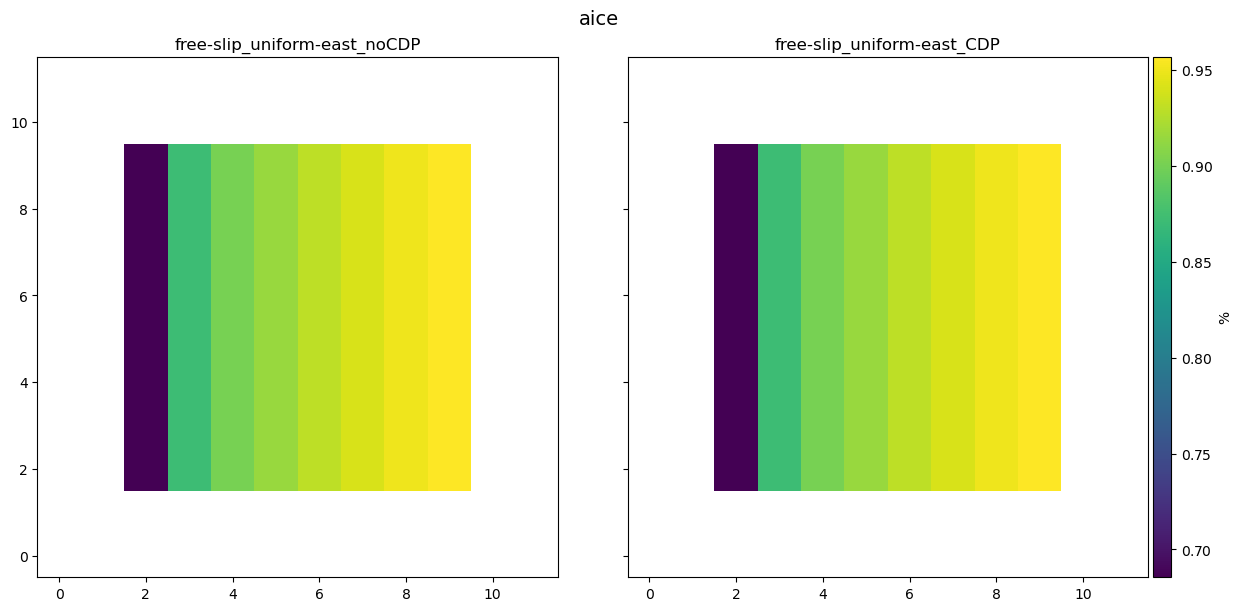

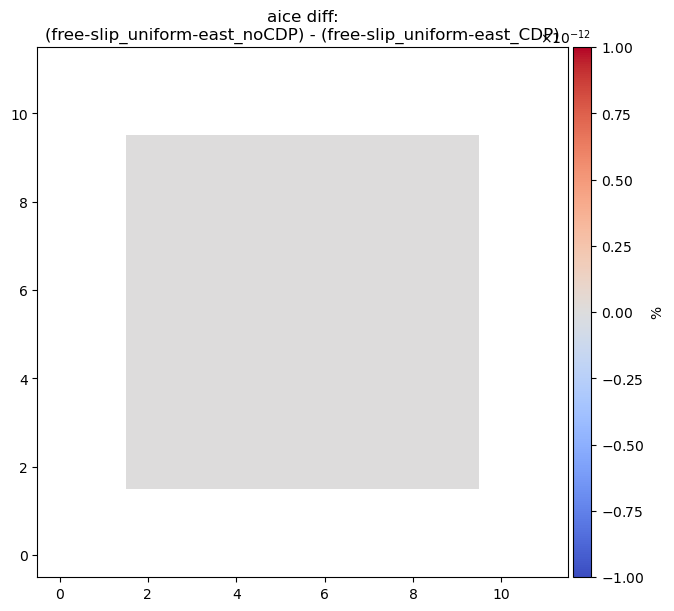

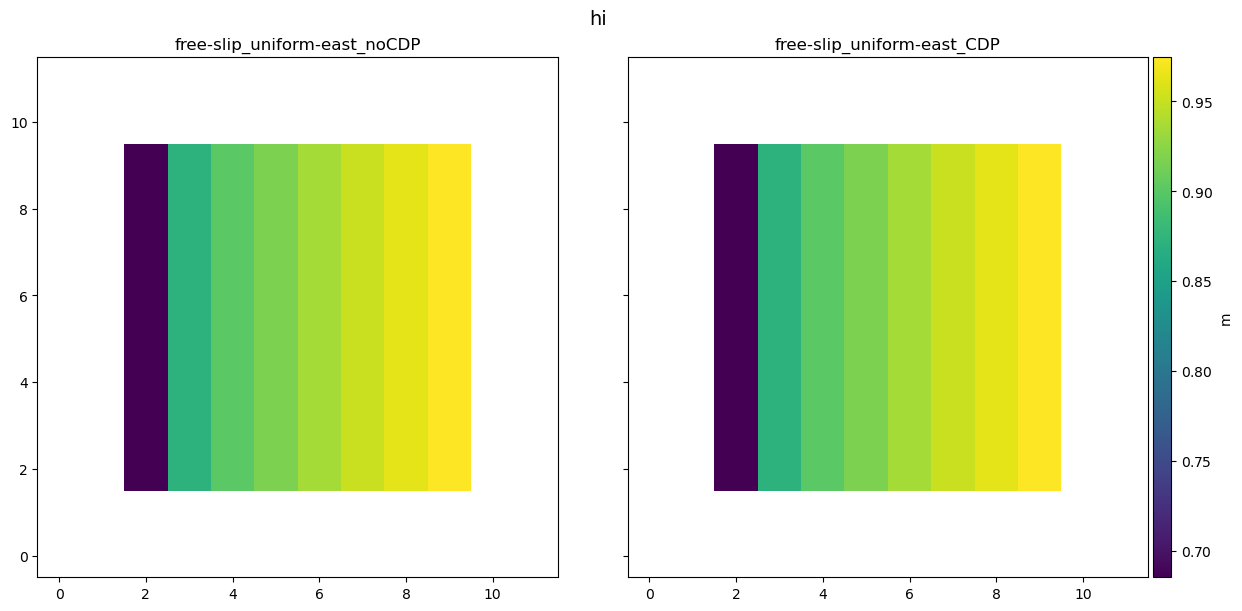

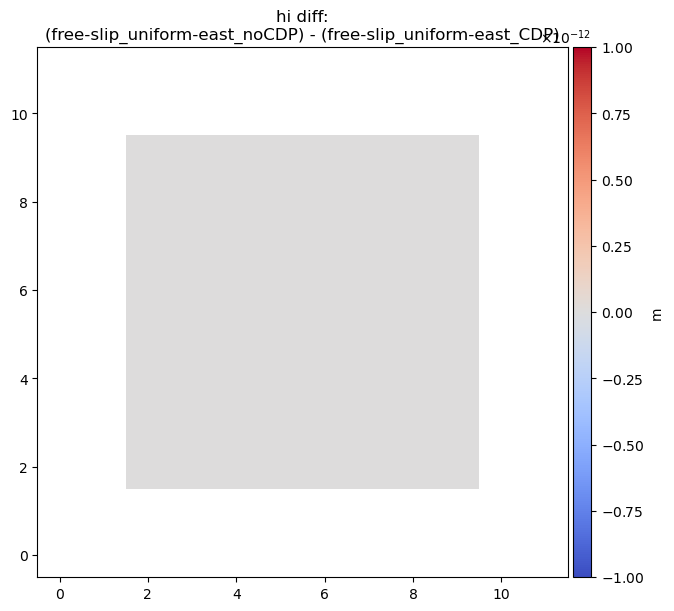

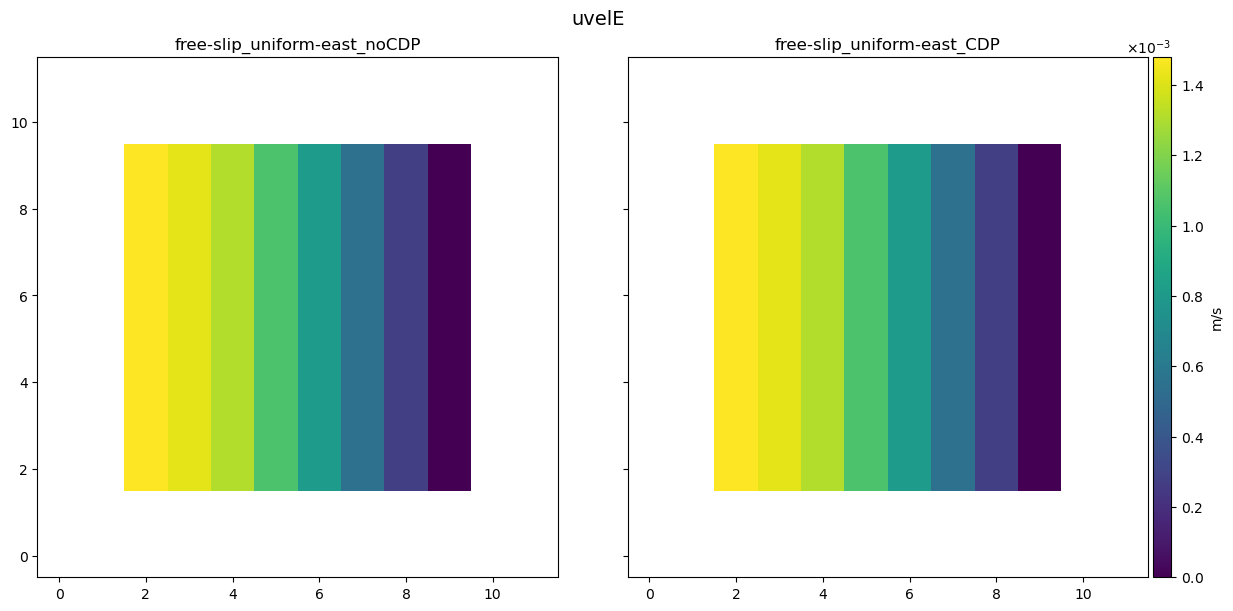

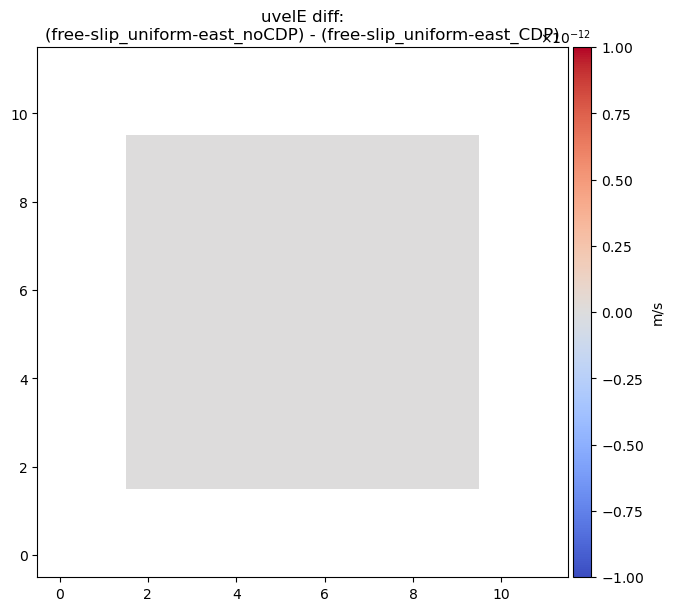

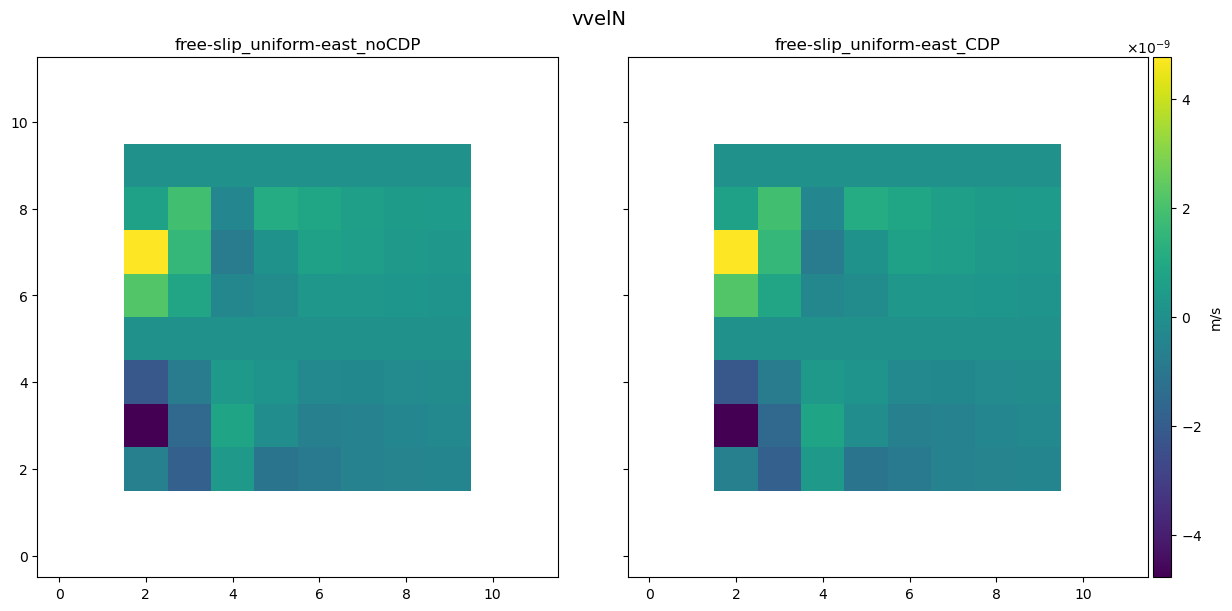

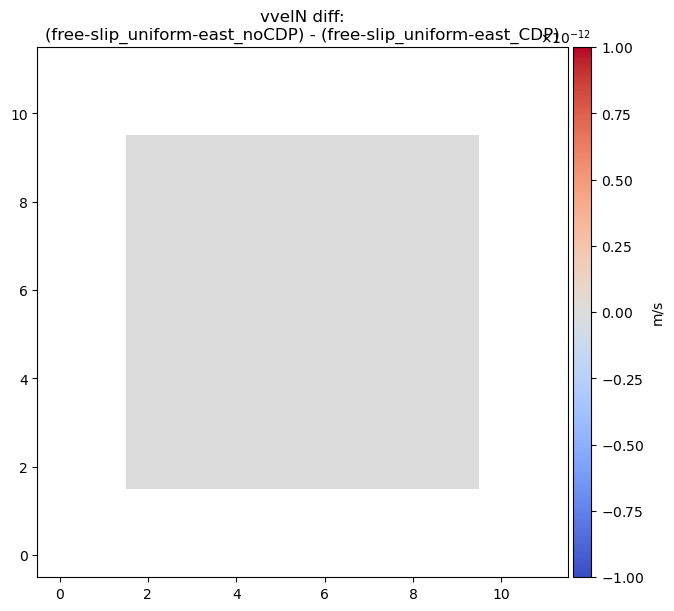

IndexError: list index out of range

In [ ]:
D_results = "/g/data/gv90/da1339/cice-dirs/runs/RESULTS"
D_graph   = "/g/data/gv90/da1339/GRAPHICAL/free-slip"
N_1       = 'free-slip_uniform-east_noCDP'
N_2       = 'free-slip_uniform-east_CDP'
P_1       = f"{D_results}/{N_1}/history"
P_2       = f"{D_results}/{N_2}/history"
F_inst    = "iceh.2005-01-04.nc"
F_inst_pat= "iceh.2005-01-*.nc"
ds1       = xr.open_dataset(f"{P_1}/{F_inst}")
ds2       = xr.open_dataset(f"{P_2}/{F_inst}")
F_base    = Path(F_inst).stem
D_comp    = Path(f"{D_graph}/{N_1}_{N_2}_{F_base}")
D_comp.mkdir(parents=True, exist_ok=True)
var_list  = ['aice', 'hi', 'uvelE', 'vvelN', 'KuxN', 'KuyE']#'uvelE_1','vvelN_1','uvelN_1','vvelE_1',]
cbar_list = ['%'   , 'm' , 'm/s'  , 'm/s'  , ''    , '']
for i,var in enumerate(var_list):
    P_vars = f"{D_comp}/{var}.png"
    P_diff = f"{D_comp}/{var}_diff.png"
    if var not in ds1 or var not in ds2:
        print(f"Skipping {var} (missing in one dataset)")
        continue
    da1 = ds1[var].isel(time=0)
    da2 = ds2[var].isel(time=0)
    plot_two_vars(da1, da2, tit_fig=var, tit1_str=N_1, tit2_str=N_2, cbar_lab=cbar_list[i], P_save=P_vars)
    diff = da1 - da2
    diff_str = f"{var} diff:\n({N_1}) - ({N_2})"
    P_sum = Path(D_comp) / f"{var}_diff_summary.txt"
    append_diff_summary(P_sum, var, N_1, N_2, diff)
    plot_diff(diff, tit_str=diff_str, cbar_lab=cbar_list[i], P_save=P_diff)

In [ ]:
animate_all_vars(P_1, P_2, F_inst_pat, var_list, N_1, N_2, D_comp, unit="m/s", fps=2)

# Coastal Drag

In [3]:
#P_ncdiff = Path( '/g/data/gv90/da1339/cice-dirs/runs/RESULTS/diff_uni-east_iceh_inst-2005-01-01-03600_free-slip-pstar-zero_v_no-slip-preCDP-pstar-zero.nc' )
P_noCDP = Path( '/home/581/da1339/CICE_runs/RESULTS/free-slip_uniform-east_noCDP/history/iceh.2005-01-03.nc' )
P_CDP   = Path( '/home/581/da1339/CICE_runs/RESULTS/free-slip_uniform-east_CDP/history/iceh.2005-01-03.nc' )
DS_noCDP = xr.open_dataset(P_noCDP)
DS_CDP   = xr.open_dataset(P_CDP)
print(f"Path to noCDP: {P_noCDP}")
print(f"Path to CDP  : {P_CDP}")
print(f"noCDP KuxN max: {DS_noCDP['KuxN'].isel(time=0).max().values}")
print(f"noCDP KuxN min: {DS_noCDP['KuxN'].isel(time=0).min().values}")
print(f"CDP KuxN max  : {DS_CDP['KuxN'].isel(time=0).max().values}")
print(f"CDP KuxN min  : {DS_CDP['KuxN'].isel(time=0).min().values}")
print(f"noCDP KuyN max: {DS_noCDP['KuyN'].isel(time=0).max().values}")
print(f"noCDP KuyN min: {DS_noCDP['KuyN'].isel(time=0).min().values}")
print(f"CDP KuyN max  : {DS_CDP['KuyN'].isel(time=0).max().values}")
print(f"CDP KuyN min  : {DS_CDP['KuyN'].isel(time=0).min().values}")
print(f"noCDP KuxE max: {DS_noCDP['KuxE'].isel(time=0).max().values}")
print(f"noCDP KuxE min: {DS_noCDP['KuxE'].isel(time=0).min().values}")
print(f"CDP KuxE max  : {DS_CDP['KuxE'].isel(time=0).max().values}")
print(f"CDP KuxE min  : {DS_CDP['KuxE'].isel(time=0).min().values}")
print(f"noCDP KuyE max: {DS_noCDP['KuyE'].isel(time=0).max().values}")
print(f"noCDP KuyE min: {DS_noCDP['KuyE'].isel(time=0).min().values}")
print(f"CDP KuyE max  : {DS_CDP['KuyE'].isel(time=0).max().values}")
print(f"CDP KuyE min  : {DS_CDP['KuyE'].isel(time=0).min().values}")
#ds['KuxN'].isel(time=0).plot(vmin=-1e-4,vmax=1e-4)

Path to noCDP: /home/581/da1339/CICE_runs/RESULTS/free-slip_uniform-east_noCDP/history/iceh.2005-01-03.nc
Path to CDP  : /home/581/da1339/CICE_runs/RESULTS/free-slip_uniform-east_CDP/history/iceh.2005-01-03.nc
noCDP KuxN max: 0.0
noCDP KuxN min: 0.0
CDP KuxN max  : 0.0
CDP KuxN min  : 0.0
noCDP KuyN max: 0.0
noCDP KuyN min: 0.0
CDP KuyN max  : 0.0
CDP KuyN min  : 0.0
noCDP KuxE max: 0.0
noCDP KuxE min: 0.0
CDP KuxE max  : 0.0
CDP KuxE min  : 0.0
noCDP KuyE max: 0.0
noCDP KuyE min: 0.0
CDP KuyE max  : 0.0
CDP KuyE min  : 0.0


In [2]:
sim_name    = "free-slip-multi" 
dt0_str     = "1993-01-01"
dtN_str     = "1994-12-31"
P_log       = Path(Path.home(), "logs", "free-slip-multi.log")
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
SI_tools    = SI_tool_mgr.get_toolbox(sim_name = sim_name,
                                      dt0_str  = dt0_str,
                                      dtN_str  = dtN_str)
SI_tools.daily_iceh_to_monthly_zarr(delete_original = True)

2026-01-02 12:34:41,272 - INFO - log file connected: /home/581/da1339/logs/free-slip-multi.log
2026-01-02 12:34:41,281 - INFO - Dask Client Connected
  Dashboard      : http://127.0.0.1:8787/status
  Threads        : 4
  Threads/Worker : [1, 1, 1, 1]
  Total Memory   : 64.00 GB

2026-01-02 12:34:41,282 - INFO - hemisphere initialised: SH
2026-01-02 12:34:41,284 - INFO - reading /g/data/gv90/da1339/afim_output/free-slip-multi/ice_diag.d to construct /g/data/gv90/da1339/afim_output/free-slip-multi/ice_in_AFIM_subset_free-slip-multi.json
2026-01-02 12:34:41,320 - INFO - [CHECK] Parsed GI_version = 0.0 from ACCESS-OM3-025_kmt.nc
2026-01-02 12:34:41,325 - INFO -  self.ice_class defined as FI_['Tb']
2026-01-02 12:34:41,326 - INFO - --- SeaIceToolbox Summary ---
2026-01-02 12:34:41,328 - INFO - Simulation Name     : free-slip-multi
2026-01-02 12:34:41,329 - INFO - Analysis Start Date : 1993-01-01
2026-01-02 12:34:41,331 - INFO - Analysis End Date   : 1994-12-31
2026-01-02 12:34:41,332 - INFO 

TypeError: Error: /g/data/gv90/da1339/afim_output/free-slip-multi/history/daily/iceh.1993-01-27.nc is not a valid NetCDF 3 file
            If this is a NetCDF4 file, you may need to install the
            netcdf4 library, e.g.,

            $ pip install netcdf4
            

In [15]:
34*730 / 3600

6.894444444444445